# Our algorithm

- **Update**:

    + *Shape vector construction*: model precipitation map into shape vector
    + *Particle justification*: perform particle matching again to justify the matched particles

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import time

## Prepare dataset

In [2]:
from src.preprocessing import read_image, windy_preprocessing_pipeline
from tqdm import tqdm

SOURCE_PATH = "data/images/philippines_13.269_123.832"

img_paths = [
    os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.png')
][:50]

img_shape = read_image(img_paths[0]).shape       # get shape of the image
print(f"Image shape: {img_shape}")
print(f"-" * 20)

dbz_maps = []

for path in tqdm(img_paths, desc="Processing images and detecting storms"):
    img = read_image(path)
    dbz_maps.append(windy_preprocessing_pipeline(img))

print(f"Number of frames: {len(dbz_maps)}")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

Image shape: (505, 1220, 3)
--------------------


Processing images and detecting storms: 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]

Number of frames: 50


## 1. Identification

In [3]:
from src.identification import HypothesisIdentifier, SimpleContourIdentifier
from src.preprocessing import convert_contours_to_polygons, convert_polygons_to_contours
from src.cores.base import StormObject, StormsMap
from datetime import datetime
from src.cores.polar_description_vector import ShapeVector, construct_shape_vector_fast, construct_sector
from shapely.geometry import Polygon
from sklearn.cluster import KMeans
from copy import deepcopy
from shapely.affinity import translate

from shapely.geometry import Point
from shapely.ops import unary_union
from shapely.affinity import rotate, translate

import rasterio.features as rfeat

THRESHOLD = 35
DISTANCE_DBZ = 5
FILTER_AREA = 20        # storm with area under this threshold => cancel
FILTER_CENTER = 10

# Implementation of storm object
RADII = [20, 40, 60, 80, 100, 120]
NUM_SECTORS = 8
DENSITY = 0.05

In [62]:
def scale_map(dbz_map: np.ndarray) -> np.ndarray:
    """
    Scale image to (0,1) ranges where min considered dbz is 20 and max is 65 dBZ
    """
    # scaled_map = (dbz_map - 20) / (65 - 20)
    # scaled_map = np.clip(scaled_map, 0, 1)
    # return scaled_map
    return (dbz_map >= 35).astype(np.float32)

def shift_mask(mask, xoff, yoff, origin=(200, 200)):
    H, W = mask.shape
    dx = xoff - origin[0]
    dy = yoff - origin[1]
    
    out = np.zeros_like(mask)
    
    # compute valid ranges
    x1 = max(0, dx)
    x2 = min(W, W + dx)
    y1 = max(0, dy)
    y2 = min(H, H + dy)
    
    out[y1:y2, x1:x2] = mask[y1-dy:y2-dy, x1-dx:x2-dx]
    return out

def construct_shape_vector_dbz(
        dbz_map: np.ndarray, particles: np.ndarray, 
        num_sectors: int = NUM_SECTORS, radii: list = RADII, shape: tuple = dbz_maps[0].shape, desc: str = ""
    ) -> np.ndarray:
    """
    Construct shape vectors for given particles based on dbz map.
    """
    # scale the dbz map to (0,1)
    scaled_map = scale_map(dbz_map)
    
    # prepare sector masks
    origin = (radii[-1], radii[-1])

    sector_mask_templates = []
    prev_base_sector = None
    for radius in RADII:
        new_sector = construct_sector(origin, radius, 0, 360/NUM_SECTORS)
        if prev_base_sector is not None:
            base_sector = new_sector.difference(prev_base_sector)
        else:
            base_sector = new_sector

        prev_base_sector = new_sector

        for j in range(num_sectors):
            sector = rotate(base_sector, j*360/num_sectors, origin=origin)
            sector_mask_templates.append(rfeat.rasterize([(sector, 1)], out_shape=shape, dtype=np.float32))

    sector_mask_templates = np.stack(sector_mask_templates, axis=-1)
    
    # construct shape vectors => shape: (num_particles, num_sectors * num_radii)
    shape_vectors = np.zeros((particles.shape[0], len(radii) * num_sectors), dtype=np.float32)

    pbar = tqdm(enumerate(particles), total=particles.shape[0], desc=desc, leave=False)

    for p_idx, (xoff, yoff) in pbar:
        shape_vector = np.zeros((len(radii) * num_sectors,), dtype=np.float32)

        for i in range(len(radii) * num_sectors):
            sector_mask = shift_mask(sector_mask_templates[:, :, i], xoff, yoff, origin)
            shape_vector[i] = np.sum(sector_mask * scaled_map)

        shape_vectors[p_idx, :] = shape_vector

    return shape_vectors

In [63]:
class ShapeVectorStorm(StormObject):
    shape_vectors: list[ShapeVector]

    def __init__(
            self, polygon: Polygon, dbz_map: np.ndarray, id: str = "",
            density: float = DENSITY, radii: list[float] = RADII, num_sectors: int = NUM_SECTORS
        ):
        # initialize with the contour and the id
        super().__init__(contour=polygon, id=id)
        contour = convert_polygons_to_contours([self.contour])[0]
        particles = self._sample_particles(contour, density)

        # create the shape vectors
        vectors = construct_shape_vector_dbz(
            dbz_map=dbz_map, particles=particles, num_sectors=num_sectors, radii=radii, 
            desc=f"Constructing shape vectors for {self.id}"
        )

        self.shape_vectors = [ShapeVector(
            coord=(coord[0], coord[1]), vector=vector
        ) for coord, vector in zip(particles.reshape(-1, 2), vectors)]
    
    def copy(self) -> "ShapeVectorStorm":
        # Allocate new object without calling __init__
        new_obj = self.__class__.__new__(self.__class__)

        # Copy all attributes manually (deepcopy for safety)
        new_obj.__dict__ = deepcopy(self.__dict__)
        new_obj.id = "pred_" + new_obj.id

        return new_obj
    
    def make_move(self, displacement: np.ndarray):
        dx, dy = displacement
        self.contour = translate(self.contour, xoff=dx, yoff=dy)
        for vector in self.shape_vectors:
            vector.coord = vector.coord[0] + dx, vector.coord[1] + dy
    
    def get_num_particles(self):
        """
        Get the number of particles.
        """
        return len(self.shape_vectors)
    
    def _sample_particles(self, contour: np.ndarray, density: float, shape = img_shape) -> np.ndarray:
        """
        Sample a list of particles inside the contour.

        Args:
            contour (np.ndarray): the list of points, in order, creating the contour.
            div (float, default): determine the number of particles = area / div.
        
        Returns:
            particles (np.ndarray): the list of particles.
        """
        # get the set of points bounded by the contour
        mask = np.zeros(shape=shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [contour], color=1)
        points = np.argwhere(mask > 0)

        # cluster them 
        n_clusters = int(cv2.contourArea(contour) * density) + 1
        k_means = KMeans(n_clusters, random_state=2025)
        k_means.fit(points)

        return k_means.cluster_centers_.astype(np.int64)[:, ::-1]   # revert the coord order.

In [64]:
# identifier = HypothesisIdentifier()
# dbz_map_sample = dbz_maps[0]

# contours = identifier.identify_storm(dbz_map_sample, 
#                                       threshold=THRESHOLD, distance_dbz_threshold=DISTANCE_DBZ, 
#                                       filter_area=FILTER_AREA, filter_center=FILTER_CENTER)

# polygons = convert_contours_to_polygons(contours)
# polygons = sorted(polygons, key=lambda p: p.area, reverse=True)

# pbar = tqdm(enumerate(polygons), total=len(polygons), desc=f"Time frame {0}", leave=False)

# storms = [ShapeVectorStorm(
#                 polygon=p, dbz_map=dbz_map_sample, id=f"storm_{i}"
#             ) for i, p in pbar
#         ]

# blank_img = np.ones(img_shape, dtype=np.uint8) * 255
# particle = storms[0].shape_vectors[0]
# coord = particle.coord

# plt.figure(figsize=(10,10))
# fig = plt.gcf()
# ax = fig.gca()

# # add sectors template
# # add circles
# for r in RADII:
#     circle = plt.Circle(coord, radius=r, color='green', fill=False, linestyle="--")
#     ax.add_patch(circle)

# # add radial lines (sectors)
# longest_r = max(RADII)
# for i in range(NUM_SECTORS):
#     grad_angle = np.deg2rad(i * (360 / NUM_SECTORS))
#     x_start, y_start = coord
#     x_end = x_start + np.cos(grad_angle) * longest_r
#     y_end = y_start + np.sin(grad_angle) * longest_r
#     plt.plot([x_start, x_end], [y_start, y_end], color="green", linewidth=1)

# print(f"Particle shape vector:\n{particle.vector}")

# plt.scatter([coord[0]], [coord[1]], color='blue', s=30)

# cv2.drawContours(blank_img, contours, -1, (255,0,0), 2)
# plt.imshow(blank_img)
# plt.ylim(450, 100)
# plt.xlim(400, 900)
# plt.show()

In [ ]:
identifier = HypothesisIdentifier(distance_dbz_threshold=DISTANCE_DBZ, filter_center=FILTER_CENTER)
# identifier = SimpleContourIdentifier()
storms_map_time_lst: list[ShapeVectorStorm] = []

for time_idx, (path, dbz_map) in tqdm(enumerate(zip(img_paths, dbz_maps)), total=len(img_paths), desc="Processing images and detecting storms"):
    file_name = path.split("/")[-1].split(".")[0]

    # Convert contours to polygons
    contours = identifier.identify_storm(dbz_map, threshold=THRESHOLD, filter_area=FILTER_AREA)
    # contours = identifier.identify_storm(dbz_map, threshold=THRESHOLD, filter_area=FILTER_AREA)
    polygons = convert_contours_to_polygons(contours)
    polygons = sorted(polygons, key=lambda x: x.area, reverse=True)

    # Construct storms map
    time_frame = datetime.strptime(file_name, "%Y%m%d-%H%M%S")
    pbar = tqdm(enumerate(polygons), total=len(polygons), desc=f"Time frame {time_frame}", leave=False)

    storms = [ShapeVectorStorm(
                polygon=polygon, 
                id=f"time_{time_idx}_storm_{idx}",
                dbz_map=dbz_map
            ) for idx, polygon in pbar]
    
    storms_map = StormsMap(storms, time_frame=time_frame)
    storms_map_time_lst.append(storms_map)

print("-"*20)

# print number of detected storms over time
for storms_map in storms_map_time_lst:
    print(f"Time: {storms_map.time_frame.strftime('%Y-%m-%d %H:%M:%S')} | Detected storms: {len(storms_map.storms)} | Particles: {sum([storm.get_num_particles() for storm in storms_map.storms])}")

print("-"*20)
# print number of detected storms over time
plt.figure(figsize=(12, 10))

plt.subplot(3,1,1)
blank_image = np.ones(img_shape, dtype=np.uint8) * 255

for storm in storms_map_time_lst[0].storms:
    color = np.random.randint(0, 255, size=3).tolist()
    coords = np.array([vector.coord for vector in storm.shape_vectors])
    x_points, y_points = coords[:, 0], coords[:, 1]
    
    plt.plot([], [], color=np.array(color)/255.0, label=f"{storm.id} \t| area = {storm.contour.area:.1f} \t| num_particles = {storm.get_num_particles()}")
    plt.scatter(x_points, y_points, color=np.array(color)/255.0, s=1)
    cv2.drawContours(blank_image, convert_polygons_to_contours([storm.contour]), -1, color, thickness=1)

# plt.legend(loc="upper right", fontsize='small', ncol=1)
plt.imshow(blank_image,cmap="grey")
plt.title('Storms objects from time frame 0')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left", fontsize='small', ncol=1)
plt.tight_layout()


plt.subplot(3,1,2)
number_of_storms = [len(storms_map.storms) for storms_map in storms_map_time_lst]
plt.plot(range(len(number_of_storms)), number_of_storms)
plt.title('Number of storms detected over time')
plt.xlabel('Time Frame Index')
plt.ylabel('Number of Storms')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.tight_layout()

plt.subplot(3,1,3)
number_of_particles = [sum([storm.get_num_particles() for storm in storms_map.storms]) for storms_map in storms_map_time_lst]
plt.plot(range(len(number_of_particles)), number_of_particles)
plt.title('Number of particles over time')
plt.xlabel('Time Frame Index')
plt.ylabel('Number of particles')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.tight_layout()
plt.show()

## 2. Tracking

### 2.1 Implementation of `Matcher`

- **Idea**: implement 2 matcher stages: `particles matching` and `storms matching`.

- **Particles matching**: match one-to-one particles using the following factors:

    + *particle distance*
    + *shape vector distance*

- **Storms matching**:

    + Perform `paricles matching` in all storms first.
    + 2 storms with matched particles rate $>$ `coarse_threshold` (*1st threshold*) are regarded as a *temporary* matched pair.
    + *Temporary* matched storms form a *cell subset*, which includes 2 parts: `sources` and `targets`. Each storm in a part is matched with at least one storm in another part.
    + *Assignment justification*: perform `paricles matching` on storms within each subset.
    + Use a 2nd threshold `fine_threshold` to filter the matched storm again.
    + Derive motion between 2 storms based on matched particles.

In [66]:
from dataclasses import dataclass, field
from shapely.affinity import translate
import warnings

@dataclass
class CellSubset:
    """
    Keep track of matched storms between 2 frames. Each storm cell in source is matched with at least one storm cell in target and vice versa.
    """
    sources: set[int]      # list of indices of source storms
    targets: set[int]      # list of indices of target storms

    def add_cell(self, source: int = None, target: int = None):
        """
        add a source/target storm index to the subcell.
        """
        if source is not None:
            self.sources.add(source)
        if target is not None:
            self.targets.add(target)
    
    def merge_subcell(self, other: "CellSubset"):
        """
        merge another subcell into this one.
        """
        self.sources = self.sources.union(other.sources)
        self.targets = self.targets.union(other.targets)

    def contains(self, storm_order: int, is_source: bool=True) -> bool:
        """
        check if the cell contains the given source/target storm index.
        """
        return (storm_order in self.sources) if is_source else (storm_order in self.targets)

@dataclass
class MatchedStormPair:
    """
    Maintain matched storms pairs information.
    """
    prev_storm_order: int
    curr_storm_order: int
    displacement_list: list = field(default_factory=list)
    prev_score: float = field(default=None)
    curr_score: float = field(default=None)

    def append_displacement(self, displacement: np.ndarray):
        self.displacement_list.append(displacement)
    
    def count_matches(self) -> int:
        return len(self.displacement_list)

    def derive_motion_vector(self, dt: float) -> np.ndarray:
        if not self.displacement_list:
            warnings.warn("No displacements recorded for this matched storm pair. Returning zero vector.")
            return np.array([0.0, 0.0])
        
        return np.mean(self.displacement_list, axis=0) / dt
    
    def set_score(self, prev_score: float, curr_score: float):
        # set scores of current matching storm pair
        self.prev_score = prev_score
        self.curr_score = curr_score

In [67]:
from src.tracking import BaseMatcher, BaseTrackingHistory, BaseTracker

@dataclass
class Particle:
    feature: ShapeVector
    storm_order: int        # order of storm in the storms_map

class ParticleMatcher(BaseMatcher):
    def _construct_disparity_matrix(
            self, particle_lst1: list[Particle], particle_lst2: list[Particle], weights: list[float]
        ) -> tuple[np.ndarray, np.ndarray]:
        """
        Construct a disparity matrix for the 2 list of shape vector objects.

        Parameters:
            particle_lst1 (list[Particle]): The first list of shape vectors.
            particle_lst2 (list[Particle]): The second list of shape vectors.
            weights (list[float]): the list of non-negative and sum-to-1 weights.

        Returns:
            cost_matrix, distance_matrix (tuple[np.ndarray, np.ndarray]): The constructed disparity matrix and distance matrix for later verification.
        """
        assert all([all([w >= 0 for w in weights]), np.sum(weights) == 1]), "weights must not be negative and must sum to 1."
        coord_1 = np.array([np.array(p.feature.coord) for p in particle_lst1])
        coord_2 = np.array([np.array(p.feature.coord) for p in particle_lst2])
        distance_matrix = np.linalg.norm(coord_1[:, None, :] - coord_2[None, :, :], axis=2)

        shape_vector_1 = np.array([p.feature.vector for p in particle_lst1])
        shape_vector_2 = np.array([p.feature.vector for p in particle_lst2])
        shape_diff_matrix = np.sqrt(np.abs(shape_vector_1[:, None, :] - shape_vector_2[None, :, :]).sum(axis=2))

        return weights[0] * distance_matrix + weights[1] * shape_diff_matrix, distance_matrix

    def match_particles(
            self, particle_lst1: list[Particle], particle_lst2: list[Particle],
            maximum_displacement: float, weights: list[float] = [0.5, 0.5]
        ) -> np.ndarray:
        """
        Match particles between 2 time frame.

        Args:
            particle_lst1 (list[Particle]): particles in the 1st frame.
            particle_lst1 (list[Particle]): particles in the 2nd frame.
        
        Returns
            assignments (np.ndarray): Array of (prev_idx, curr_idx) pairs representing matched particles.
        """
        cost_matrix, displacement_matrix = self._construct_disparity_matrix(particle_lst1, particle_lst2, weights=weights)
        invalid_mask = displacement_matrix > maximum_displacement

        cost_matrix = cost_matrix + invalid_mask.astype(np.float64) * 3000      # add penalty to those violated
        row_ind, col_ind = self._hungarian_matching(cost_matrix)

        assignment_mask = np.zeros_like(invalid_mask, dtype=bool)
        assignment_mask[row_ind, col_ind] = True

        return np.argwhere(assignment_mask & np.logical_not(invalid_mask))
    

class SubsetResolver:
    """
    Manage the subsets of matched storms.
    """
    matching_threshold: float

    def __init__(self, matching_threshold: float):
        self.matching_threshold = matching_threshold
    
    def create_subsets(self, assignments: list[tuple[int, int]]) -> list[CellSubset]:
        """
        create subsets of storms based on the `assignments` between 2 time frames.
        """
        subcells: list[CellSubset] = []

        for prev_idx, curr_idx in assignments:
            prev_subcell = None
            curr_subcell = None

            # find if there is existing subcell containing prev_idx or curr_idx
            for subcell in subcells:
                if subcell.contains(prev_idx, is_source=True):
                    prev_subcell = subcell
                if subcell.contains(curr_idx, is_source=False):
                    curr_subcell = subcell
            
            # case 1: both are not belonged to any subcell => create new subcell
            if not prev_subcell and not curr_subcell:
                # create new subcell
                new_subcell = CellSubset(sources={prev_idx}, targets={curr_idx})
                subcells.append(new_subcell)
                continue
                
            # case 2: only one of them is belonged to a subcell => add the other index to that subcell
            if prev_subcell and not curr_subcell:
                prev_subcell.add_cell(target=curr_idx)
                continue
            if not prev_subcell and curr_subcell:
                curr_subcell.add_cell(source=prev_idx)
                continue
                
            # case 3: both are belonged to different subcells => merge the 2 subcells
            if prev_subcell != curr_subcell:
                prev_subcell.merge_subcell(curr_subcell)
                subcells.remove(curr_subcell)
        
        return subcells


    def resolve_subsets(
            self, subset_lst: list[CellSubset], storms_map_lst_1: StormsMap, storms_map_lst_2: StormsMap, 
            max_velocity: float, weights: list[float] = [0.5, 0.5]
        ) -> list[MatchedStormPair]:
        """
        justify the matched particles within each subset to get final assignments between 2 time frames.
        """
        # compute maximum displacement
        dt = (storms_map_lst_2.time_frame - storms_map_lst_1.time_frame).total_seconds() / 3600.0
        maximum_displacement = max_velocity * dt
        particles_matcher = ParticleMatcher()

        valid_storm_pairs: list[MatchedStormPair] = []

        for subset in subset_lst:
            prev_storms_lst: list[tuple[int, ShapeVectorStorm]] = [(idx, storm) for idx, storm in enumerate(storms_map_lst_1.storms) if idx in subset.sources]
            curr_storms_lst: list[tuple[int, ShapeVectorStorm]] = [(idx, storm) for idx, storm in enumerate(storms_map_lst_2.storms) if idx in subset.targets]

            particles_prev: list[Particle] = [Particle(feature=v, storm_order=idx) 
                                              for idx, storm in prev_storms_lst for v in storm.shape_vectors]
            particles_curr: list[Particle] = [Particle(feature=v, storm_order=idx) 
                                              for idx, storm in curr_storms_lst for v in storm.shape_vectors]

            # match particles
            particle_assignments = particles_matcher.match_particles(
                particles_prev, particles_curr, maximum_displacement, weights
            )

            matched_storms_dict = {}

            # collect matched particles information for each pair of storms
            for idx1, idx2 in particle_assignments:
                prev_storm_order = particles_prev[idx1].storm_order
                curr_storm_order = particles_curr[idx2].storm_order

                if (prev_storm_order, curr_storm_order) not in matched_storms_dict:
                    matched_storms_dict[(prev_storm_order, curr_storm_order)] = MatchedStormPair(
                        prev_storm_order=prev_storm_order,
                        curr_storm_order=curr_storm_order
                    )
                
                displacement = np.array(particles_curr[idx2].feature.coord) - np.array(particles_prev[idx1].feature.coord)
                matched_storms_dict[(prev_storm_order, curr_storm_order)].append_displacement(displacement)

            for (prev_storm_order, curr_storm_order), matched_pair in matched_storms_dict.items():
                num_particles_prev = storms_map_lst_1.storms[prev_storm_order].get_num_particles()
                num_particles_curr = storms_map_lst_2.storms[curr_storm_order].get_num_particles()
                min_particles = min(num_particles_prev, num_particles_curr)

                score = matched_pair.count_matches() / min_particles
                if score >= self.matching_threshold:
                    # score based on prev and curr storm
                    matched_pair.set_score(matched_pair.count_matches() / num_particles_prev, matched_pair.count_matches() / num_particles_curr)
                    valid_storm_pairs.append(matched_pair)
        
        return valid_storm_pairs


class StormMatcher(BaseMatcher):
    max_velocity: float
    particle_matcher: ParticleMatcher

    def __init__(self, max_velocity: float):
        self.max_velocity = max_velocity
    
    def _construct_disparity_matrix(self, object_lst1, object_lst2):
        pass

    def match_storms(
            self, storms_map_lst_1: StormsMap, storms_map_lst_2: StormsMap,
            coarse_threshold: float = 0.4, fine_threshold: float = 0.5
        ) -> list[MatchedStormPair]:
        """
        Match storms between 2 time frame.

        Args:
            storm_map1 (StormsMap): storm map in the 1st frame.
            storm_map2 (StormsMap): storm map in the 2nd frame.
        
        Returns:
            tuple[np.ndarray, list, list]:
                assignments (nd.ndarray): list of pairs of corresponding id of 2 storms.
                probability_matrix (list): list of score of corresponding assignment.
                displacements (list): list of displacement of corresponding assignment.
        """
        particles_prev: list[Particle] = [Particle(feature=v, storm_order=idx) for idx, storm in enumerate(storms_map_lst_1.storms)\
                          for v in storm.shape_vectors]
        particles_curr: list[Particle] = [Particle(feature=v, storm_order=idx) for idx, storm in enumerate(storms_map_lst_2.storms)\
                          for v in storm.shape_vectors]
        
        dt = (storms_map_lst_2.time_frame - storms_map_lst_1.time_frame).seconds / 3600
        maximum_displacement = self.max_velocity * dt
        
        if len(particles_prev) == 0 or len(particles_curr) == 0:
            return [], [], []

        self.particle_matcher = ParticleMatcher()
        particle_assignments = self.particle_matcher.match_particles(
                particles_prev, particles_curr, maximum_displacement=maximum_displacement
            )
        
        # map particles assignment back to storm.
        particles_id_prev = [p.storm_order for p in particles_prev]
        particles_id_curr = [p.storm_order for p in particles_curr]

        mapping_displacements = {curr_idx: {prev_idx: [] for prev_idx in range(len(storms_map_lst_1.storms))}\
                                 for curr_idx in range(len(storms_map_lst_2.storms))}
        
        for (p_prev_idx, p_curr_idx) in particle_assignments:
            p_prev = particles_prev[p_prev_idx].feature.coord
            p_curr = particles_curr[p_curr_idx].feature.coord
            displacement = np.array(p_curr) - np.array(p_prev)

            mapping_displacements[particles_id_curr[p_curr_idx]][particles_id_prev[p_prev_idx]].append(displacement)
        
        # count number of matched particles between each pair of storms
        matching_count = np.zeros((len(storms_map_lst_1.storms), len(storms_map_lst_2.storms)), dtype=np.int64)

        for idx1, idx2 in particle_assignments:
            matching_count[particles_prev[idx1].storm_order, particles_curr[idx2].storm_order] += 1
        
        # compute probability matrix
        ## p_A: Probability of matching where the denominator is the number of particles in the previous storm
        ## p_B: Probability of matching where the denominator is the number of particles in the curr storm
        p_A = matching_count / np.array([storm.get_num_particles() for storm in storms_map_lst_1.storms])[:, np.newaxis]
        p_B = matching_count / np.array([storm.get_num_particles() for storm in storms_map_lst_2.storms])[np.newaxis, :]

        p = np.max([p_A, p_B], axis=0)
        assignments = np.argwhere(p > coarse_threshold)

        # resolve subsets
        subset_resolver = SubsetResolver(matching_threshold=coarse_threshold)
        subsets = subset_resolver.create_subsets(assignments.tolist())
        valid_matched_storms = subset_resolver.resolve_subsets(
            subsets, storms_map_lst_1, storms_map_lst_2, max_velocity=self.max_velocity, weights=[0.5, 0.5]
        )

        return valid_matched_storms

### 2.2 Implementation of `TrackHistory`

In [ ]:
@dataclass
class StormRecord:
    """
    Record: is a part of `StormTrack`, contains information about a storm at a specific time frame.
    """
    track_id: int
    storm: ShapeVectorStorm
    time_frame: datetime
    is_virtual: bool = field(default=False)      # if virtual: the current storm of the corresponding track is splitted and this storm is created to keep track of the splitted part.
    parent_track_id: int = field(default=None)   # if virtual: the id of the parent track from which this storm is splitted.

@dataclass
class StormTrack:
    """
    Track: contains the history of a storm over time frames.
    """
    id: int
    records: list[StormRecord] = field(default_factory=list)
    movements: list[np.ndarray] = field(default_factory=list)   # list of movement vectors over time
    active: bool = field(default=True)                          # whether the track is still active or not
    merged: bool = field(default=False)                         # in case the track is inactive, check whether the track has been merged into another track
    merged_to: int = field(default=None)                        # if merged, the id of the track to which this track is merged

    def add_record(self, record: StormRecord, motion_vector: np.ndarray = None):
        self.records.append(record)
        if motion_vector is not None:
            self.movements.append(motion_vector)
    
    def get_latest_record(self) -> StormRecord:
        return self.records[-1] if self.records else None
    
    def get_copy(self, new_id: int, last_time: datetime) -> "StormTrack":
        """
        Return a copy of the current track with a new id.
        """
        new_track = StormTrack(id=new_id)
        new_track.records = deepcopy(self.records)
        for record in new_track.records:
            record.track_id = new_id
            record.is_virtual = True
            record.parent_track_id = self.id

        for movement in self.movements:
            new_track.movements.append(deepcopy(movement))

        if len(new_track.records) > 0 and new_track.records[-1].time_frame >= last_time:
            # drop the last record if it exceeds the last time
            new_track.records.pop()
            if len(new_track.movements) > 0:
                new_track.movements.pop()

        return new_track

In [70]:
from shapely.affinity import translate

class TrackingHistory(BaseTrackingHistory):
    tracks: list[StormTrack] = []
    storm_dict: dict[str, int] = {}      # mapping from storm id to track id
    active_list: list[int] = []          # list of active track ids

    def __init__(self, storms_map: StormsMap):
        self.tracks = []
        for storm in storms_map.storms:
            self.tracks.append(self._initialize_track(storm, storms_map.time_frame))
        
        self.storm_dict = {storm.id: idx for idx, storm in enumerate(storms_map.storms)}
        self.active_list = list(range(len(self.tracks)))
    
    def _initialize_track(self, storm: ShapeVectorStorm, time_frame: datetime):
        new_id = len(self.tracks)
        return StormTrack(
            id=new_id,
            records=[StormRecord(
                track_id=new_id,
                storm=storm,
                time_frame=time_frame
            )]
        )

    def _get_track(self, storm_id: str) -> StormTrack:
        """
        Get the track of storm with storm_id, if there is no track found, raise `KeyError`.

        Args:
            storm_id (str): id of the storm
        
        Returns:
            track (dict): the track information of the storm.
        """
        if storm_id not in self.storm_dict:
            raise KeyError(f"Storm {storm_id} not found in the current track.")
        track_id = self.storm_dict[storm_id]
        return self.tracks[track_id]

    def _interpolate_velocity(self, velocity_lst: list[np.ndarray], alpha_decay: float = 0.5):
        if len(velocity_lst) == 1:
            return velocity_lst[0]
        
        weights = np.array([alpha_decay**i for i in range(len(velocity_lst))])
        total_w = np.sum(weights)
        return np.sum([displ * w / total_w for displ, w in zip(velocity_lst[::-1], weights)], axis=0)
    
    def forecast(self, storm_id: str, dt: float, default_motion: np.ndarray = np.array([0,0])) -> ShapeVectorStorm:
        """
        Make a forecast for the next position of the track with track_id using the history.
        
        Args:
            storm_id (int): id of the storm.
            dt (float): the interval between the current and next frame.
            default_motion (np.ndarray, default): default motion used in case there is no recorded history.
        
        Returns:
            storm (CentroidStorm): the estimated storm in the next frame.
        """
        track = self._get_track(storm_id)
        if not track.active:
            warnings.warn(f"Storm {storm_id} is expired. Forecast might be inaccurate.")
            
        curr_storm: ShapeVectorStorm = track.records[-1].storm

        velocity_lst = track.movements
        if len(velocity_lst) == 0:      # if no recorded velocity => use the default motion.
            velocity_lst = [default_motion]
        
        displacement = self._interpolate_velocity(velocity_lst) * dt
        new_storm = curr_storm.copy()
        new_storm.make_move(displacement)

        return new_storm

    def update(
            self, mapping_curr: dict[int, list], inherited_dict: dict[int, dict], prev_storms_map: StormsMap, curr_storms_map: StormsMap
        ):
        """
        Update the tracking history using the new mapping data.

        Args:
            curr_matching_list (list): list of matched storms information where list's indices are storm indices in the current storms map.
            time_frame (datetime): time of current mapping.
        """
        active_lst = []         # update the new active list
        merge_lst = []          # list of merged storms information to be handled later.
        curr_time = curr_storms_map.time_frame
        # prev_time = prev_storms_map.time_frame

        # dt = (curr_time - prev_time).seconds / 3600

        def update_track(prev_storm_order: int, curr_storm_order: int, motion_vector: np.ndarray) -> int:
            """
            Update the track of the current assignment and return the track id.
            """
            prev_storm_idx = prev_storms_map.storms[prev_storm_order].id
            curr_storm = curr_storms_map.storms[curr_storm_order]
            curr_storm_idx = curr_storm.id

            # check if the parent track is virtual (due to splitting) or not
            virtual = inherited_dict[curr_storm_order].get("virtual", None)
            if virtual is None:
                warnings.warn(f"Cannot find inherited information for storm {curr_storm_order}. Assuming parent track is not virtual.")

            ## case *.1: parent track is not virtual => update into existing track
            if virtual is False:
                # print(f"update existing track for storm {curr_storm.id} from parent storm {prev_storms_map.storms[prev_storm_order].id}")
                parent_track = self._get_track(prev_storm_idx)

                parent_track.add_record(
                    StormRecord(
                        track_id=parent_track.id,
                        storm=curr_storm,
                        time_frame=curr_time,
                    ),
                    motion_vector=motion_vector
                )

                self.storm_dict[curr_storm_idx] = parent_track.id
                return parent_track.id
            
            ## case *.2: parent track is virtual => create a new track from the parent track
            else:
                parent_track = self._get_track(prev_storm_idx)
                new_id = len(self.tracks)
                new_track = parent_track.get_copy(new_id=new_id, last_time=curr_time)
                new_track.add_record(StormRecord(
                        track_id=new_id,
                        storm=curr_storm,
                        time_frame=curr_time,
                    ),
                    motion_vector=motion_vector
                )

                self.tracks.append(new_track)
                self.storm_dict[curr_storm_idx] = new_id
                
                return new_id

        for curr_storm_order, matched_list in mapping_curr.items():
            curr_storm = curr_storms_map.storms[curr_storm_order]
            matched_list = sorted(matched_list, key=lambda x: x[2], reverse=True)

            # case 1: no matched storms => create new track
            if len(matched_list) == 0:
                new_track = self._initialize_track(
                    curr_storm, curr_time
                )
                self.tracks.append(new_track)
                new_id = len(self.tracks) - 1
                self.storm_dict[curr_storm.id] = new_id
                active_lst.append(new_id)
            
            # case 2: only one matched storm => continue the track
            elif len(matched_list) == 1:
                prev_storm_order, _, _, motion_vector = matched_list[0]

                track_id = update_track(prev_storm_order, curr_storm_order, motion_vector)
                active_lst.append(track_id)
            
            # case 3: multiple matched storms => mark as merged for later handling
            else:
                # update the parent storm into the main track
                prev_storm_order, _, _, motion_vector = matched_list[0]   # get the one with highest number of matched particles
                track_id = update_track(prev_storm_order, curr_storm_order, motion_vector)
                active_lst.append(track_id)

                # for others, mark them as 'merged'
                for prev_storm_order, _, _, motion_vector in matched_list[1:]:   # sort by number of matched particles
                    prev_storm_idx = prev_storms_map.storms[prev_storm_order].id
                    merged_track_id = self.storm_dict[prev_storm_idx]
                    track = self.tracks[merged_track_id]
                    track.merged_to = track_id

                    merge_lst.append(merged_track_id)

        # update active status
        for id in self.active_list:
            if id not in active_lst:
                self.tracks[id].active = False

            if id in merge_lst:
                self.tracks[id].merged = True
        
        self.active_list = sorted(active_lst)

    def print_tracks(self):
        for id, track in enumerate(self.tracks):
            if track.active:
                status = "ACTIVE"
            elif track.merged:
                status = f"MERGED to track {track.merged_to}"
            else:
                status = "EXPIRED"

            print(f"Track {id:2d}. " + " -> ".join(record.storm.id for record in track.records))
            print(f"Id: {track.id}")
            print(f"Status: {status}")
            print(f"Lifespan: {len(track.records)}")
            print(f"Last track: {track.records[-1].time_frame.strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"-" * 50)

### 2.3 Implementation of `Tracker`

- **Idea**: a common class that keep everything about the tracking step.

- **Methods**:
    - $\textcolor{yellow}{\text{fit}}$: receive the list of storms over time, match them step-by-step and record the tracking history.
    - $\textcolor{yellow}{\text{predict}}$: predict the next position of the current track.

In [71]:
from src.cores.metrics import pod_score, far_score, csi_score
from src.tracking import BaseTracker

class Tracker(BaseTracker):
    matcher: StormMatcher
    tracker: TrackingHistory

    def __init__(self, max_velocity: float):
        self.matcher = StormMatcher(max_velocity)
        
    def fit(self, storms_map_time_lst: list[StormsMap], coarse_threshold: float, fine_threshold: float, test=False):
        self.tracker = TrackingHistory(storms_map_time_lst[0])
        print(f"Number of initial tracks: {len(self.tracker.tracks)}")
        csi_scores, far_scores, pod_scores, frames = [], [], [], []

        # return csi_scores, far_scores, pod_scores, frames

        for idx in range(0, len(storms_map_time_lst)-1):
            # get the current maps
            prev_storms_map, curr_storms_map = storms_map_time_lst[idx], storms_map_time_lst[idx+1]
            dt = (curr_storms_map.time_frame - prev_storms_map.time_frame).seconds / 3600   # scaled to hour
            
            if test:
                pred_storms_map = StormsMap([
                    self.tracker.forecast(storm.id, dt) for storm in prev_storms_map.storms
                ], time_frame=curr_storms_map.time_frame)

                csi_scores.append(csi_score(pred_storms_map, curr_storms_map))
                far_scores.append(far_score(pred_storms_map, curr_storms_map))
                pod_scores.append(pod_score(pred_storms_map, curr_storms_map))
                frames.append(curr_storms_map.time_frame)

            # 1. Match storms between frames using Hungarian algorithm
            matched = self.matcher.match_storms(prev_storms_map, curr_storms_map, coarse_threshold=coarse_threshold, fine_threshold=fine_threshold)

            # 2. Build mapping from current → list of matched previous storms
            mapping_curr = {i: [] for i in range(len(curr_storms_map.storms))}

            for pair in matched:
                mapping_curr[pair.curr_storm_order].append((
                    pair.prev_storm_order,
                    pair.curr_score,
                    pair.prev_score,
                    pair.derive_motion_vector(dt),
                ))

            # 3. Resolve merge/split cases
            inherited = {}  # curr_idx → parent info
            parent_children = {i: [] for i in range(len(prev_storms_map.storms))}

            # 3a. Assign each current storm its best previous parent
            for curr_idx, matches in mapping_curr.items():
                if not matches:
                    continue

                # select previous storm with highest curr_score
                parent_prev_idx, _, prev_score, _ = max(matches, key=lambda x: x[1])

                inherited[curr_idx] = {'parent_id': parent_prev_idx, 'virtual': False}
                parent_children[parent_prev_idx].append((curr_idx, prev_score))

            # 3b. Detect splits: a previous storm inherited by >1 current storms
            for _, children in parent_children.items():
                if len(children) <= 1:
                    continue

                # sort by parent_score descending
                children_sorted = sorted(children, key=lambda x: x[1], reverse=True)

                # first keeps real ID, others become virtual (split)
                for curr_idx, _ in children_sorted[1:]:
                    inherited[curr_idx]['virtual'] = True

            # 4. Update tracker with resolved matching
            self.tracker.update(mapping_curr, inherited, prev_storms_map, curr_storms_map)
        
        if test:
            return csi_scores, far_scores, pod_scores, frames

    def predict(self, storm: ShapeVectorStorm, dt: float):
        try:
            return self.tracker.forecast(storm.id, dt)
        except KeyError:
            print(f"❗ Storm not found on the track. `None` will be returned.")
            return None

In [72]:
MAX_VELOCITY = 50  # unit: pixel/hr
MATCHING_COARSE_THRESHOLD = 0.45
MATCHING_FINE_THRESHOLD = 0.5

tracker = Tracker(max_velocity=MAX_VELOCITY)
csi_scores, far_scores, pod_scores, frames = tracker.fit(
        storms_map_time_lst, coarse_threshold=MATCHING_COARSE_THRESHOLD, fine_threshold=MATCHING_FINE_THRESHOLD, test=True
    )

tracker.tracker.print_tracks()

Number of initial tracks: 11
Track  0. time_0_storm_0 -> time_1_storm_0
Id: 0
Status: MERGED to track 13
Lifespan: 2
Last track: 2025-01-08 03:16:44
--------------------------------------------------
Track  1. time_0_storm_1 -> time_1_storm_1
Id: 1
Status: MERGED to track 13
Lifespan: 2
Last track: 2025-01-08 03:16:44
--------------------------------------------------
Track  2. time_0_storm_2 -> time_1_storm_4 -> time_2_storm_8
Id: 2
Status: MERGED to track 11
Lifespan: 3
Last track: 2025-01-08 03:22:45
--------------------------------------------------
Track  3. time_0_storm_3
Id: 3
Status: MERGED to track 6
Lifespan: 1
Last track: 2025-01-08 03:10:44
--------------------------------------------------
Track  4. time_0_storm_4 -> time_1_storm_3 -> time_2_storm_4 -> time_3_storm_4 -> time_4_storm_5 -> time_5_storm_8 -> time_6_storm_13
Id: 4
Status: MERGED to track 13
Lifespan: 7
Last track: 2025-01-08 03:46:46
--------------------------------------------------
Track  5. time_0_storm_5 -

In [73]:
from src.cores.metrics import pod_score, far_score, csi_score

bm_pod_scores = []
bm_far_scores = []
bm_csi_scores = []

print("Naive nowcasting prediction: Only using the last map without any motion update")
print("Results:")
for idx in range(len(storms_map_time_lst)-1):
    prev_storm = storms_map_time_lst[idx]
    curr_storm = storms_map_time_lst[idx+1]
    bm_pod_scores.append(pod_score(prev_storm, curr_storm))
    bm_far_scores.append(far_score(prev_storm, curr_storm))
    bm_csi_scores.append(csi_score(prev_storm, curr_storm))
    print(f"\tTime {curr_storm.time_frame.strftime('%Y-%m-%d %H:%M:%S')} | POD: {pod_score(prev_storm, curr_storm):.4f} | FAR: {far_score(prev_storm, curr_storm):.4f} | CSI: {csi_score(prev_storm, curr_storm):.4f}")

Naive nowcasting prediction: Only using the last map without any motion update
Results:
	Time 2025-01-08 03:16:44 | POD: 0.9154 | FAR: 0.0951 | CSI: 0.8351
	Time 2025-01-08 03:22:45 | POD: 0.7932 | FAR: 0.5218 | CSI: 0.4252
	Time 2025-01-08 03:28:45 | POD: 0.8986 | FAR: 0.1545 | CSI: 0.7719
	Time 2025-01-08 03:34:45 | POD: 0.8945 | FAR: 0.1646 | CSI: 0.7605
	Time 2025-01-08 03:40:45 | POD: 0.6867 | FAR: 0.4947 | CSI: 0.4106
	Time 2025-01-08 03:46:46 | POD: 0.8715 | FAR: 0.1426 | CSI: 0.7611
	Time 2025-01-08 03:52:46 | POD: 0.4461 | FAR: 0.5755 | CSI: 0.2780
	Time 2025-01-08 03:58:46 | POD: 0.8244 | FAR: 0.2353 | CSI: 0.6576
	Time 2025-01-08 04:04:46 | POD: 0.8010 | FAR: 0.1854 | CSI: 0.6775
	Time 2025-01-08 04:10:47 | POD: 0.7098 | FAR: 0.3527 | CSI: 0.5118
	Time 2025-01-08 04:16:47 | POD: 0.8456 | FAR: 0.1519 | CSI: 0.7344
	Time 2025-01-08 04:22:47 | POD: 0.4203 | FAR: 0.6451 | CSI: 0.2383
	Time 2025-01-08 04:28:47 | POD: 0.7256 | FAR: 0.3909 | CSI: 0.4951
	Time 2025-01-08 04:34:48 | 

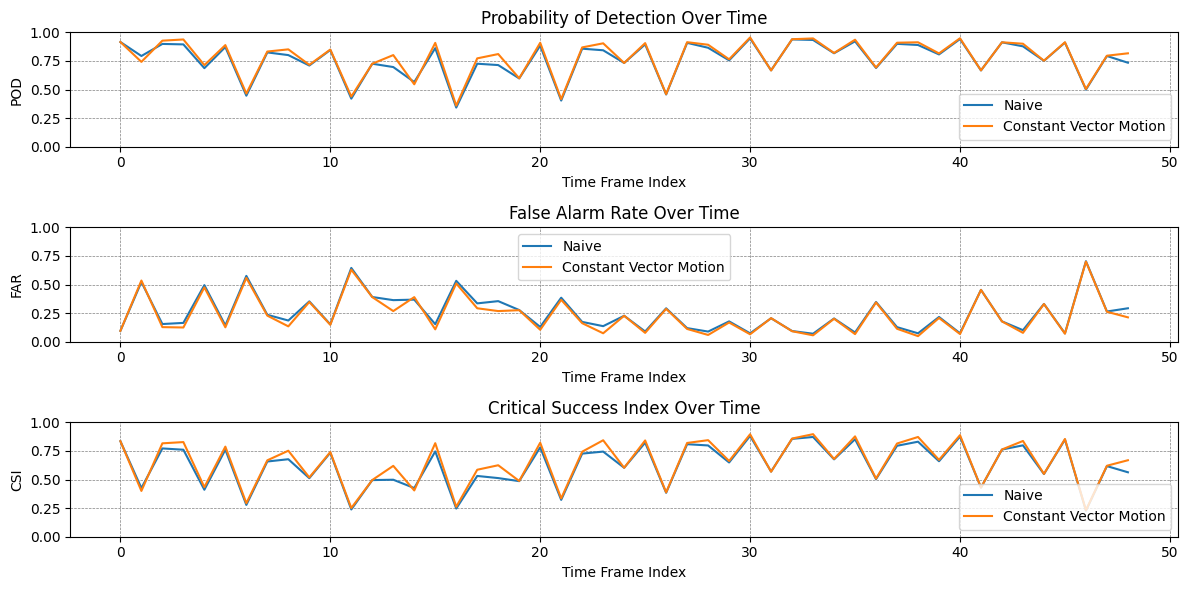

In [74]:
indexes = range(len(bm_pod_scores))
scores = [
    (bm_pod_scores, pod_scores), 
    (bm_far_scores, far_scores),
    (bm_csi_scores, csi_scores)
]
titles = ['Probability of Detection Over Time', 'False Alarm Rate Over Time', 'Critical Success Index Over Time']
ylabels = ['POD', 'FAR', 'CSI']

plt.figure(figsize=(12, 6))

for i, title in enumerate(titles):
    plt.subplot(3, 1, i+1)
    plt.plot(indexes, scores[i][0], label='Naive')
    plt.plot(indexes, scores[i][1], label='Constant Vector Motion')
    plt.title(title)
    plt.xlabel('Time Frame Index')
    plt.ylabel(ylabels[i])
    plt.ylim(0, 1)
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    plt.legend()

plt.tight_layout()
plt.show()